## 3. Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import re
import distance
from fuzzywuzzy import fuzz
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

C:\Users\hp\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



### 3.1 Read data and basic stats

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
print('Number of datapoints: ', df.shape[0])

Number of datapoints:  404290


In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


#### Observation
We have 2 missing datapoints in question 2 col(404289) and 1 in question 1(404288) 

In [6]:
df.loc[df['question1'].isna()]

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [7]:
df.loc[df.question2.isna()]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


## 3.2.1 Distribution of data points among output classes.

Number of duplicates(similar) and non duplicate(non similar) questions

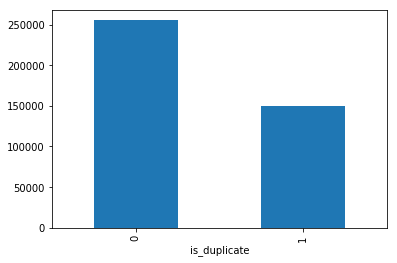

In [8]:
df.groupby('is_duplicate')['id'].count().plot(kind='bar')

In [9]:
print('-> Total number of question pairs for training: \n', df.shape[0])

-> Total number of question pairs for training: 
 404290


In [10]:
print('-> Total number of Question pairs that are not similar(non duplicates): \n{}({}%)'.format(df.groupby('is_duplicate')['id'].count()[0], np.round((df.groupby('is_duplicate')['id'].count()[0]/df.groupby('is_duplicate')['id'].count().sum()), 2)*100))

print('\n')

print('-> Total number of Question pairs that are similar(duplicates): \n{}({}%)'.format(df.groupby('is_duplicate')['id'].count()[1], np.round((df.groupby('is_duplicate')['id'].count()[1]/df.groupby('is_duplicate')['id'].count().sum()), 2)*100))

-> Total number of Question pairs that are not similar(non duplicates): 
255027(63.0%)


-> Total number of Question pairs that are similar(duplicates): 
149263(37.0%)


In [11]:
df.groupby('is_duplicate')['id'].count().sum()

404290

### 3.2.2 Number of unique questions

In [12]:
[1,2,3] + [4,5,6]

[1, 2, 3, 4, 5, 6]

In [13]:
questions_ids = pd.Series(df['qid1'].tolist(), df['qid2'].tolist())
unique_ids = questions_ids.nunique()
questions_more_than_one_time = np.sum(questions_ids.value_counts() > 1)
print('Total Number of Unique Questions are: \n{}'.format(unique_ids))

print('Number of Questions that appear more than once: \n{}'.format( ((questions_more_than_one_time)/(np.sum(questions_ids.value_counts())))*100 ))

print('Max number of times a Question is repeated: \n{}'.format(questions_ids.value_counts().max()))

q_vals = questions_ids.value_counts().values

Total Number of Unique Questions are: 
290654
Number of Questions that appear more than once: 
13.374805214079002
Max number of times a Question is repeated: 
50


In [14]:
len(np.unique(questions_ids))

290654

In [15]:
unique_ids

290654

In [16]:
np.sum(questions_ids.value_counts() > 1)

54073

In [17]:
questions_ids.value_counts().max()

50

In [18]:
questions_ids.value_counts().values

array([50, 48, 47, ...,  1,  1,  1], dtype=int64)

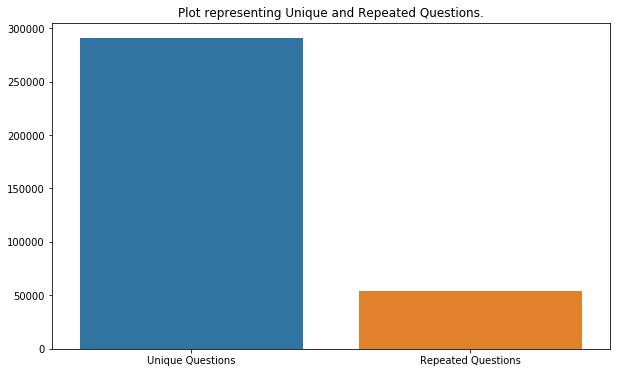

In [19]:
y = [unique_ids, questions_more_than_one_time]
x = ['Unique Questions', 'Repeated Questions']

plt.figure(figsize=(10,6))
plt.title('Plot representing Unique and Repeated Questions.')
sns.barplot(x,y)

## 3.2.3 Checking for Duplicates

In [20]:
pair_duplicates = df[['qid1', 'qid2', 'is_duplicate']].groupby(['qid1', 'qid2']).count().reset_index()

In [21]:
pair_duplicates.head()

,qid1,qid2,is_duplicate
0,1,2,1
1,3,4,1
2,3,282170,1
3,3,380197,1
4,3,488853,1


In [22]:
print('Number of duplicate questions: \n', pair_duplicates.shape[0] - df.shape[0])

Number of duplicate questions: 
 0


Text(0, 0.5, 'Number of Questions')

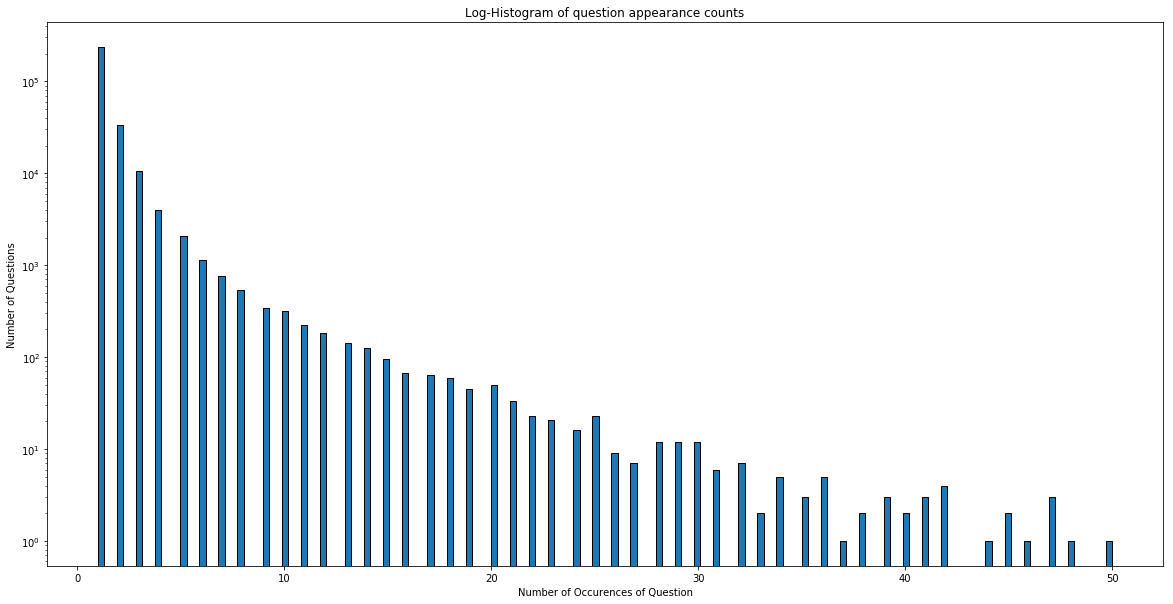

In [23]:
plt.figure(figsize=(20,10))
plt.hist(questions_ids.value_counts(), bins=160, edgecolor='black')
plt.yscale('log')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of Occurences of Question')
plt.ylabel('Number of Questions')

### 3.2.5 Checking for NAN values

In [24]:
# Check whether there are any rows with NAN 
df[df.isna().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [25]:
# Filling the null values with ' ' (empty string)
df = df.fillna(' ')

## 3.3 Basic Feature Extraction(before cleaning)

Let us now construct a few features like:
<ul>
    <li><strong>freq_id1</strong> -> Frequency of id 1</li>
    <li><strong>freq_id2</strong> -> Frequency of id 2</li>
    <li><strong>q1len</strong> -> String length of question 1</li>
    <li><strong>q2len</strong> -> String length of question 2</li>
    <li><strong>q1_n_words</strong> -> Number of words in question 1.</li>
    <li><strong>q2_n_words</strong> -> Number of words in question 2.</li>
    <li><strong>word_Common</strong> -> Number of Common unique words in question 1 and question 2.</li>
<li><strong>word_Total</strong> -> (Total Number of words in Question 1 + Total Number of words in Question 2)</li>
    <li><strong>word_share</strong> -> (word_Common)/(q1_n_words + q2_n_words)</li>
    <li><strong>freq_id1 + freq_id2</strong></li>
    <li><strong>freq_id1 - freq_id2</strong></ul>

In [26]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv('df_fe_without_preprocessing_train.csv')
else:
    print('Dataframe is originally of shape: ', df.shape)
    print('Addding simple features.........')
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len()
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda question: len(question.split(' ')))
    df['q2_n_words'] = df['question2'].apply(lambda question: len(question.split(' ')))
    print('Now its of shape: ', df.shape)
    
    def normalized_word_common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(' ')))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(' ')))
        return 1.0 * len(w1 & w2)
    
    df['word_common'] = df.apply(normalized_word_common, axis=1)
    print('Now its of shape: ', df.shape)
    
    def normalized_word_total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(' ')))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(' ')))
        return 1.0 * (len(w1) + len(w2))
    
    df['word_total'] = df.apply(normalized_word_total, axis=1)
    print('Now its of shape: ', df.shape)
    
    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(' ')))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(' ')))
        return 1.0 * len(w1 & w2) / (len(w1) + len(w2))

    df['word_share'] = df.apply(normalized_word_share, axis=1)
    print('Now its of shape: ', df.shape)
    
    df['freq_q1+freq_q2'] = df['freq_qid1'] + df['freq_qid2']
    print('Now its of shape: ', df.shape)
    
    df['freq_q1-freq_q2'] = abs(df['freq_qid1'] - df['freq_qid2'])
    print('Now its of shape: ', df.shape)
    
    df.to_csv('df_fe_without_preprocessing_train.csv', index=False)

In [27]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+freq_q2,freq_q1-freq_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [28]:
df.shape

(404290, 17)

In [29]:
len(set([1,2,4,5]) & set([3, 4, 5]))

2

In [30]:
questions_ids.values

array([     1,      3,      5, ..., 537928, 537930, 537932], dtype=int64)

In [31]:
df.groupby('qid1')['qid1'].transform('count')

0          1
1          4
2          1
3          1
4          3
          ..
404285     2
404286    12
404287     1
404288     1
404289     1
Name: qid1, Length: 404290, dtype: int64

In [32]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+freq_q2,freq_q1-freq_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0


### 3.3.1 Analysis of some of the extracted features

In [33]:
print('Minimum length of the words in question1: ', df['q1_n_words'].min())
print('Minimum length of the words in question2: ', df['q2_n_words'].min())
print('Number of words with minimum length [question1]: ', df[df['q1_n_words'] == df['q1_n_words'].min()].shape[0])
print('Number of words with minimum length [question2]: ', df[df['q2_n_words'] == df['q2_n_words'].min()].shape[0])

Minimum length of the words in question1:  1
Minimum length of the words in question2:  1
Number of words with minimum length [question1]:  66
Number of words with minimum length [question2]:  22


#### 3.3.1.1 Feature: word share

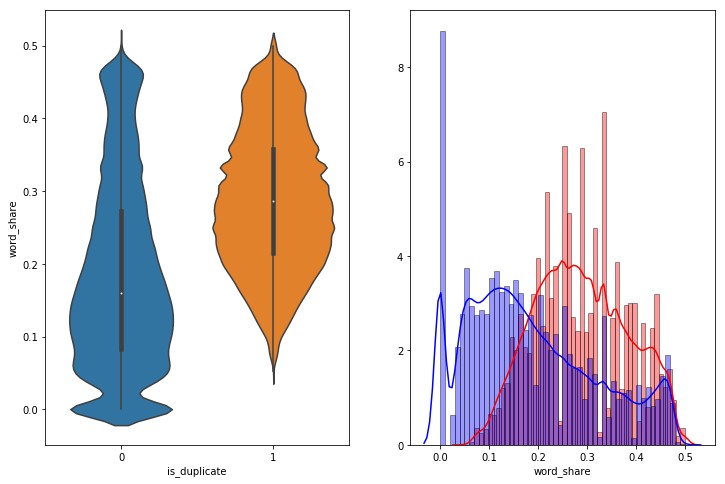

In [34]:
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='word_share', data=df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'], label='1', color='red', hist_kws={'edgecolor': 'black'})
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'], label='2', color='blue', hist_kws={'edgecolor': 'black'})

#### Observations
In the violin plot, I see that the duplicate questions(where is_duplicate = 1) have a higher word share count than the non_duplicate ones  with a median of about 0.3
 
 The pdfs have some overlap but it shows the word_share feature is useful.

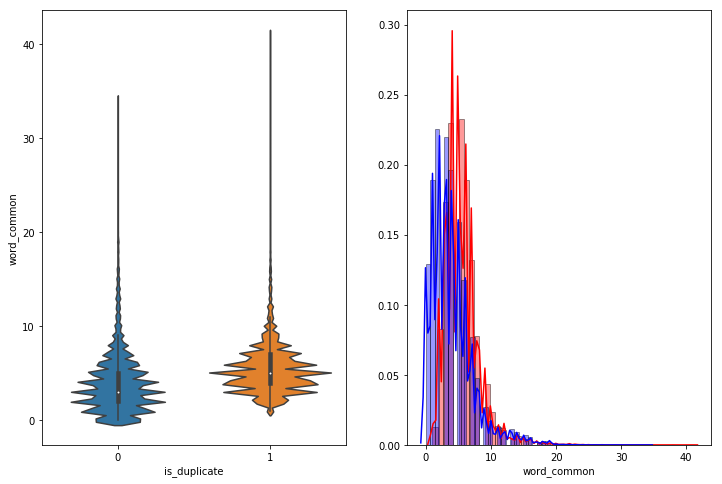

In [35]:
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='word_common', data=df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_common'], label='1', color='red', hist_kws={'edgecolor': 'black'})
sns.distplot(df[df['is_duplicate'] == 0.0]['word_common'], label='2', color='blue', hist_kws={'edgecolor': 'black'})

## 3.4 Preprocessing of Text

<ul>
    <li>Preprocessing</li>
    <ul>
        <li>Removing html tags</li>
        <li>Removing punctuations</li>
        <li>Performing stemming</li>
        <li>Removing stopwords</li>
        <li>Expanding contractions</li>
    </ul>
</ul>

In [36]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+freq_q2,freq_q1-freq_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [37]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

In [38]:
type('')

str

In [39]:
re.sub(re.compile('\W'), ' ', 'knot')

'knot'

In [40]:
re.sub(re.compile('\W'), ' ', '')

''

In [41]:
BeautifulSoup('knot').get_text()

'knot'

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

In [42]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [43]:
[0.0]*10

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [44]:
# Get the longest common substring
def get_longest_common_substring(q1, q2):
    strings = list(distance.lcsubstrings(q1, q2))
    if len(strings) == 0:
        return 0
    else:
        return len(strings[0]) / (min(len(q1), len(q2)) + 1)

In [45]:
distance.lcsubstrings("sedentar", "dentist")

{'dent'}

In [46]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("data/train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [47]:
df.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.99998,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759


<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [48]:
df_duplicate = df[df['is_duplicate'] == 1]
df_nonduplicate = df[df['is_duplicate'] == 0]

In [49]:
df_duplicate.shape

(149263, 21)

In [50]:
149263 * 2

298526

In [51]:
# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate['question1'], df_duplicate['question2']]).flatten()
n = np.dstack([df_nonduplicate['question1'], df_nonduplicate['question2']]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_duplicates.txt', p, delimiter=' ', fmt='%s', encoding='utf-8')
np.savetxt('train_nonduplicates.txt', n, delimiter=' ', fmt='%s', encoding='utf-8')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [52]:
# stop_words

In [53]:
# reading the text files and removing the Stop Words:
d = os.path.dirname('.')

textp_w = open(os.path.join(d, 'train_duplicates.txt'), encoding='utf-8').read()
textn_w = open(os.path.join(d, 'train_nonduplicates.txt'), encoding='utf-8').read()
stpwords = set(STOPWORDS)
stpwords.add('said')
stpwords.add('br')
stpwords.add(' ')
stpwords.remove('not')
stpwords.remove('no')

WordCloud for duplicate Question pairs.


(-0.5, 399.5, 199.5, -0.5)

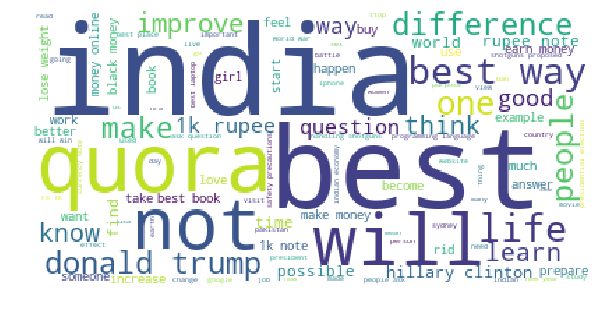

In [54]:
plt.figure(figsize=(10,8))
wc = WordCloud(background_color='white', max_words=len(textp_w), stopwords=stpwords)
wc.generate(textp_w)
print('WordCloud for duplicate Question pairs.')
plt.imshow(wc)
plt.axis('off')

WordCloud for Non Duplicate Question pairs.


(-0.5, 399.5, 199.5, -0.5)

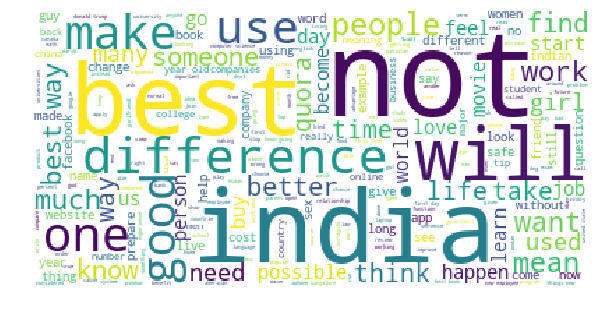

In [55]:
plt.figure(figsize=(10,8))
wc = WordCloud(background_color='white', max_words=len(textn_w), stopwords=stpwords)
wc.generate(textn_w)
print('WordCloud for Non Duplicate Question pairs.')
plt.imshow(wc)
plt.axis('off')

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 21 columns):
id                      404290 non-null int64
qid1                    404290 non-null int64
qid2                    404290 non-null int64
question1               404275 non-null object
question2               404284 non-null object
is_duplicate            404290 non-null int64
cwc_min                 404290 non-null float64
cwc_max                 404290 non-null float64
csc_min                 404290 non-null float64
csc_max                 404290 non-null float64
ctc_min                 404290 non-null float64
ctc_max                 404290 non-null float64
last_word_eq            404290 non-null float64
first_word_eq           404290 non-null float64
abs_len_diff            404290 non-null float64
mean_len                404290 non-null float64
token_set_ratio         404290 non-null int64
token_sort_ratio        404290 non-null int64
fuzz_ratio              404290 non-null

In [57]:
df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']].head(2)

,ctc_min,cwc_min,csc_min,token_sort_ratio,is_duplicate
0,0.916659,0.999980,0.999983,93,0
1,0.699993,0.799984,0.749981,63,0


In [58]:
df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:df.shape[0]].head()

,ctc_min,cwc_min,csc_min,token_sort_ratio,is_duplicate
0,0.916659,0.999980,0.999983,93,0
1,0.699993,0.799984,0.749981,63,0
2,0.399996,0.399992,0.399992,63,0
3,0.000000,0.000000,0.000000,24,0
4,0.571420,0.399992,0.999950,47,0


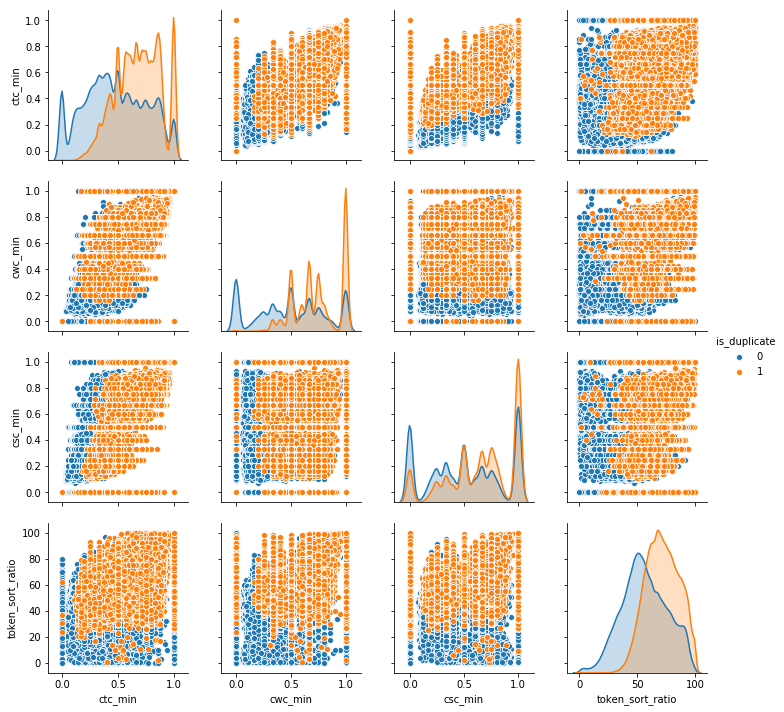

In [59]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], 
             hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

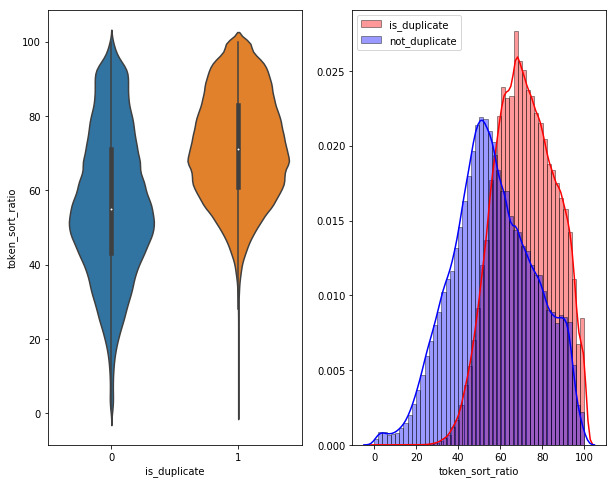

In [60]:
# Distribution of toke_sort_ratio
plt.figure(figsize=(10,8))

plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='token_sort_ratio', data=df)

plt.subplot(1, 2, 2)
sns.distplot(df[df['is_duplicate'] == 1]['token_sort_ratio'], label='is_duplicate', color='red', hist_kws={'edgecolor': 'black'})
sns.distplot(df[df['is_duplicate'] == 0]['token_sort_ratio'], label='not_duplicate', color='blue', hist_kws={'edgecolor': 'black'})
plt.legend()

### Observations
Duplicate pairs tend to have a higher token_sort_ratio compared to non-duplicate pairs.

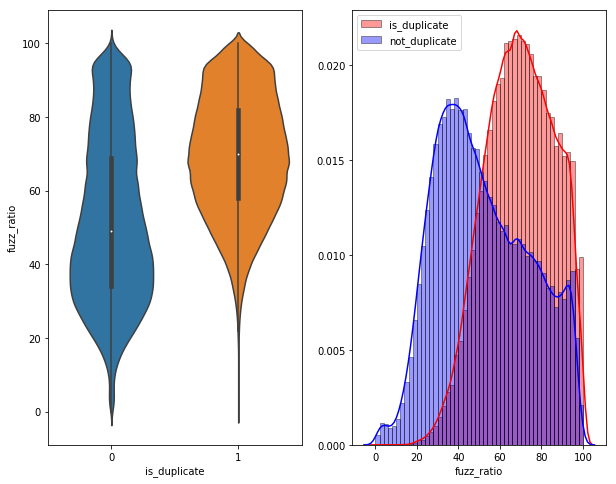

In [61]:
# Distribution of fuzz_ratio
plt.figure(figsize=(10,8))

plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='fuzz_ratio', data=df)

plt.subplot(1, 2, 2)
sns.distplot(df[df['is_duplicate'] == 1]['fuzz_ratio'], label='is_duplicate', color='red', hist_kws={'edgecolor': 'black'})
sns.distplot(df[df['is_duplicate'] == 0]['fuzz_ratio'], label='not_duplicate', color='blue', hist_kws={'edgecolor': 'black'})
plt.legend()

#### Observations
Same as token_sort_ratio, hi9gher values of fuzz-ratio for duplicates than non-duplicates

<h3>3.5.2 Visualization </h3>

In [62]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [63]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 2 dimention

from sklearn.preprocessing import MinMaxScaler

df_sampled = df.sample(10000)

X = MinMaxScaler().fit_transform(df_sampled.drop(['is_duplicate', 'id', 'qid1', 'qid2', 'question1', 'question2'], axis=1))
y = df_sampled['is_duplicate'].values

In [64]:
from sklearn.manifold import TSNE

In [65]:
tsne2d = TSNE(n_components=2, random_state=101, n_iter=1000, verbose=2).fit_transform(X, y)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.133s...
[t-SNE] Computed neighbors for 10000 samples in 1.307s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.108632
[t-SNE] Computed conditional probabilities in 0.588s
[t-SNE] Iteration 50: error = 95.5431519, gradient norm = 0.0244146 (50 iterations in 3.931s)
[t-SNE] It

In [66]:
tsne2d

array([[-22.444504 ,  28.119267 ],
       [ 12.832784 , -66.50597  ],
       [ 47.014004 ,  66.139275 ],
       ...,
       [-45.675224 ,   6.457329 ],
       [-44.42708  ,  -7.8780203],
       [ 11.544182 , -16.240019 ]], dtype=float32)

C:\Users\hp\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



Text(0.5, 1.0, 'TSNE with perplexity=30 and iterations=1000')

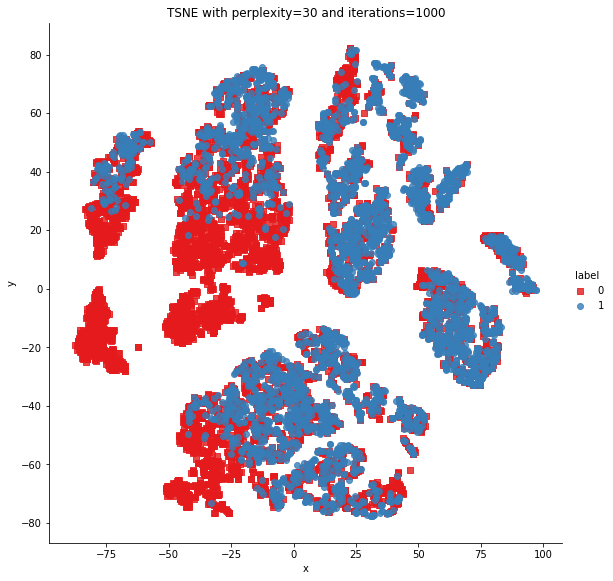

In [67]:
sns.lmplot(data=pd.DataFrame({'x': tsne2d[:, 0], 'y': tsne2d[:, 1], 'label': y}), x='x', y='y', hue='label', 
           fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title('TSNE with perplexity=30 and iterations=1000')

<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [68]:
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sys
from tqdm import tqdm
import spacy

In [69]:
data = pd.read_csv('data/train.csv')

In [70]:
# Avoiding decoding issues
data['question1'] = data['question1'].apply(lambda x:str(x))
data['question2'] = data['question2'].apply(lambda x:str(x))

In [71]:
# merge texts
questions = list(data['question1']) + list(data['question2'])

In [72]:
tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)

word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [73]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
import en_core_web_sm

In [74]:
nlp = en_core_web_sm.load()

In [75]:
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(data['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)

100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [1:11:26<00:00, 94.33it/s]


In [88]:
df['q1_feats_m'] = list(vecs1)

In [89]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_feats_m
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[78.6829916536808, 87.63591205328703, 77.89881..."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[99.99300765991211, 55.174563616514206, -2.049..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[62.709637857973576, 72.48951929807663, 10.889..."
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[35.00679123401642, -40.4132185280323, 53.4504..."
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[135.42515441775322, 187.44562482833862, 143.6..."


In [78]:
vecs2 = []
for qu2 in tqdm(list(data['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)

100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [1:12:36<00:00, 92.80it/s]


In [79]:
df['q2_feats_m'] = list(vecs2)

In [80]:
for w in nlp(data['question1'][0]):
    print(w.vector)

[-1.2883725   0.06341369 -0.9661109  -1.142952    4.1682096  -2.234582
 -0.9946718   1.2739408   0.1092546   0.5226963   2.1630263  -1.1154673
  1.1566892   1.402261   -0.72432584  1.7320623   0.7500889  -0.77212816
 -0.1860044  -3.153451    2.0074894  -0.06370062  0.14745924 -3.350438
 -1.2301555   2.3868046   0.9613056   3.7713218   1.9812332   2.2421463
 -0.0091157   1.7426124   1.2536641  -1.5256691   0.41197217  2.2325397
 -1.7473311  -2.4331725  -2.2657943   0.8722334   0.3258504   4.9408383
  2.8765469  -0.8501614   1.747674   -3.7728653  -1.7448305   1.0353076
  1.1227622  -3.222896   -0.62118703  3.9260466  -1.4213581   2.8452332
 -2.8256743  -2.295041    3.1233864   0.51243496 -4.153756    1.4628032
 -1.8536518   0.53350985  0.596383    1.97471    -1.3313442   3.943726
 -1.5151634   1.8141476   1.4503925  -0.975235   -2.4737308  -1.0527942
  0.34848306 -3.0480664   6.290694   -0.45342433  0.38989788 -3.6212811
 -1.8537271  -2.3486433  -0.27717102 -0.24614656  0.10868296  2.51

In [81]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,q2_feats_m
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,"[69.93877413868904, 62.04867684841156, 65.4711..."
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,"[100.52318406105042, 60.70732665061951, 114.13..."
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.0,1.0,4.0,12.0,63,63,43,47,0.166667,"[28.12277317047119, -0.2629050612449646, -8.95..."
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,2.0,12.0,28,24,9,14,0.039216,"[22.605501174926758, -22.139145493507385, 18.2..."
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.0,1.0,6.0,10.0,67,47,35,56,0.175000,"[1.1583712100982666, 29.232888340950012, 66.42..."


In [82]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv('nlp_features_train.csv', encoding='latin-1')
else:
    print("get nlp_features_train.csv from running previous notebook")
    
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfprepro = pd.read_csv('df_fe_without_preprocessing_train.csv', encoding='latin-1')
else:
    print("get df_fe_without_preprocessing_train.csv from running previous notebook")

In [83]:
dfnlp.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.99998,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759


In [84]:
df.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,q2_feats_m
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.99998,0.833319,0.999983,0.999983,...,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,"[69.93877413868904, 62.04867684841156, 65.4711..."


In [90]:
df['q1_feats_m'].values[0].tolist()

[78.6829916536808,
 87.63591205328703,
 77.8988194912672,
 -61.47369161248207,
 44.05322623252869,
 18.525177627801895,
 -28.609311521053314,
 47.452460408210754,
 -86.09560988843441,
 58.907952308654785,
 -5.908886790275574,
 5.062266707420349,
 136.38463148474693,
 -29.311245679855347,
 -6.9082207679748535,
 -104.90581914782524,
 106.75476968288422,
 16.799190416932106,
 -23.684500575065613,
 76.53409957885742,
 113.29254454374313,
 35.874052472412586,
 48.696722745895386,
 -11.65375429391861,
 -36.54151952266693,
 99.91537527740002,
 -142.43833661079407,
 -72.02859556674957,
 -1.3741747736930847,
 -129.17499381303787,
 -25.437617633491755,
 -42.14692211151123,
 37.407021909952164,
 -69.26975584030151,
 -73.93612325191498,
 -19.662359982728958,
 38.20989012718201,
 -9.545737624168396,
 -44.94793495815247,
 -56.5455738902092,
 103.3511325865984,
 -41.77351671457291,
 -1.6152699440717697,
 -86.68553614616394,
 179.61423368938267,
 -32.611244052648544,
 51.47985124588013,
 8.15370011329

In [91]:
df1 = dfnlp.drop(['qid1', 'qid2', 'question1', 'question2'], axis=1)
df2 = dfprepro.drop(['qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis=1)
df3 = df.drop(['qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index=df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index=df3.index)

In [92]:
# dataframe of nlp features
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [93]:
# data before preprocessing 
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+freq_q2,freq_q1-freq_q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [94]:
# Questions 1 tfidf weighted word2vec
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,78.682992,87.635912,77.898819,-61.473692,44.053226,18.525178,-28.609312,47.452460,-86.095610,58.907952,...,7.157678,86.842601,38.238606,-25.909486,3.169638,-54.031532,-112.663659,1.619508,81.309565,-17.361949
1,99.993008,55.174564,-2.049167,36.677249,85.412371,-45.989080,31.112590,76.453094,-74.456509,110.348369,...,-64.475704,27.344039,-22.471263,-23.111044,-97.185489,13.815928,-24.577477,72.654378,58.654857,-19.836278
2,62.709638,72.489519,10.889310,-45.772860,71.261772,-34.385969,-26.228285,18.224490,-113.496336,115.968702,...,77.008272,5.414788,-26.222928,35.709896,-49.750098,-74.032807,-130.011004,-84.557644,10.153947,-30.314630
3,35.006791,-40.413219,53.450493,-45.069038,37.137247,-21.992808,-28.184323,131.916699,41.891510,27.243861,...,-36.975472,25.987250,-74.511655,-45.798322,42.739461,-17.318146,37.957786,-47.867102,-101.418604,-3.919247
4,135.425154,187.445625,143.612776,-111.735024,56.977977,-70.101866,-47.585533,59.575895,-56.992457,253.326808,...,-34.521699,74.533560,-3.963831,-77.077944,27.673524,-87.661703,-146.777092,1.730535,5.950078,-12.494797


In [95]:
# Questions 2 tfidf weighted word2vec
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,69.938774,62.048677,65.471186,-65.080995,37.007811,11.953720,-44.908971,39.077935,-71.113359,64.970021,...,15.591466,96.113849,31.001480,-44.172052,21.397091,-46.908810,-100.162247,-1.978221,38.112752,-11.592531
1,100.523184,60.707327,114.135677,-2.311834,28.477254,-0.705671,113.688085,117.816506,-93.662698,81.227491,...,-84.838611,54.099417,-65.543286,-23.634332,-85.303453,33.143694,-65.774337,28.145018,-22.243213,0.169092
2,28.122773,-0.262905,-8.952834,-14.151883,18.908912,40.142980,62.036967,60.638759,-79.254361,108.044290,...,27.926253,33.117176,66.706154,50.397498,42.266215,-29.920099,-53.378103,-31.755547,77.061497,9.438696
3,22.605501,-22.139145,18.226516,-20.430915,22.291252,35.642941,-31.471534,61.818255,-40.677339,33.871990,...,-7.491278,44.788221,6.437781,39.981581,-43.237003,39.471643,-0.322382,-6.074735,-4.417220,5.627428
4,1.158371,29.232888,66.428352,-43.949273,12.497666,6.992168,-57.236839,32.344526,-56.251407,48.231540,...,44.084751,37.174410,0.356843,-29.468567,33.367771,-12.860933,-44.425541,3.958389,-13.291972,-9.029029


In [96]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 221


In [97]:
df1.head().merge(df2.head(), how='left', on='id').head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+freq_q2,freq_q1-freq_q2
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,...,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,...,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,...,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [98]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df3_q1['id'] = df1['id']
    df3_q2['id'] = df1['id']
    df1 = df1.merge(df2, how='left', on='id')
    df2 = df3_q1.merge(df3_q2, how='left', on='id')
    result = df1.merge(df2, how='left', on='id')
    result.to_csv('final_features.csv')

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [99]:
from sqlalchemy import create_engine
import sqlite3
import datetime as dt

In [100]:
# Creating a db file from csv
if not os.path.isfile('train.db'):
    engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    for df in pd.read_csv('final_features.csv', chunksize=chunksize, iterator=True, encoding='utf-8'):
        j+=1
        print('{} rows.'.format(chunksize*j))
        df.to_sql('data', engine, if_exists='append')
        start_index = df.index[-1] + 1

In [101]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [102]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [103]:
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        data  = pd.read_sql_query("""SELECT * FROM data ORDER BY RANDOM()""", conn_r)
        conn_r.commit()
        conn_r.close()

In [104]:
data.shape

(404290, 222)

In [105]:
data.head()

,index,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,401021,401021,401021,1,0.666644,0.499988,0.749981,0.428565,0.624992,0.454541,...,22.555267,63.108339,20.809367,-7.664331,30.019983,22.965554,-54.695958,-24.730279,38.300328,-29.405943
1,160984,160984,160984,0,0.000000,0.000000,0.333322,0.249994,0.166664,0.111110,...,34.530925,22.727656,-4.905155,18.782976,33.797020,-13.683048,-55.212595,-44.119906,9.783556,4.831744
2,32292,32292,32292,0,0.187499,0.187499,0.571424,0.499997,0.323528,0.274999,...,38.615227,81.366001,-23.075725,147.964682,-66.506318,77.021277,-157.913861,-49.111122,-100.940682,-157.820681
3,22416,22416,22416,0,0.999967,0.999967,0.666644,0.399992,0.833319,0.624992,...,18.806703,17.804426,-13.259817,-11.732350,63.613485,-18.314457,-55.714867,-32.617665,-8.746877,-13.114440
4,315848,315848,315848,0,0.199996,0.142855,0.499988,0.399992,0.333330,0.249998,...,3.654520,1.191643,17.137995,52.822863,-15.924963,77.982629,86.661192,-93.903955,19.251345,-45.790505


In [106]:
data.head(2)

,index,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,401021,401021,401021,1,0.666644,0.499988,0.749981,0.428565,0.624992,0.454541,...,22.555267,63.108339,20.809367,-7.664331,30.019983,22.965554,-54.695958,-24.730279,38.300328,-29.405943
1,160984,160984,160984,0,0.000000,0.000000,0.333322,0.249994,0.166664,0.111110,...,34.530925,22.727656,-4.905155,18.782976,33.797020,-13.683048,-55.212595,-44.119906,9.783556,4.831744


In [107]:
data.drop(['index', 'Unnamed: 0', 'id'], axis=1, inplace=True)

In [108]:
y_true = data['is_duplicate']

In [109]:
data.drop('is_duplicate', axis=1, inplace=True)

<h2> 4.2 Converting strings to numerics </h2>

In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Columns: 218 entries, cwc_min to 95_y
dtypes: float64(206), int64(12)
memory usage: 672.4 MB


In [111]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = data.columns
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_common
word_total
word_share
freq_q1+freq_q2
freq_q1-freq_q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y

In [112]:
y_true = list(map(int, y_true.values))

<h2> 4.3 Random train test split( 70:30) </h2>

In [113]:
from sklearn.model_selection import train_test_split

In [114]:
data.head(2)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0.666644,0.499988,0.749981,0.428565,0.624992,0.454541,1.0,1.0,3.0,9.5,...,22.555267,63.108339,20.809367,-7.664331,30.019983,22.965554,-54.695958,-24.730279,38.300328,-29.405943
1,0.000000,0.000000,0.333322,0.249994,0.166664,0.111110,0.0,1.0,3.0,7.5,...,34.530925,22.727656,-4.905155,18.782976,33.797020,-13.683048,-55.212595,-44.119906,9.783556,4.831744


In [115]:
X_train, X_test, y_train, y_test = train_test_split(data, y_true, test_size=0.3, stratify=y_true)

In [116]:
print("Number of data points in train data :", X_train.shape[0])
print("Number of data points in test data :", X_test.shape[0])

Number of data points in train data : 283003
Number of data points in test data : 121287


In [117]:
from collections import Counter

In [118]:
print('-'*10, "Distribution of output variable in train data", '-'*10)
train_distribution = Counter(y_train)
train_len = len(y_train)
print("Class 0: {}, Class 1: {}".format(train_distribution[0]/train_len, train_distribution[1]/train_len))

print('-'*10, "Distribution of output variable in test data", '-'*10)
test_distribution = Counter(y_test)
test_len = len(y_test)
print("Class 0: {}, Class 1: {}".format(test_distribution[0]/test_len, test_distribution[1]/test_len))

---------- Distribution of output variable in train data ----------
Class 0: 0.6308025003268517, Class 1: 0.36919749967314835
---------- Distribution of output variable in test data ----------
Class 0: 0.6308013224830361, Class 1: 0.3691986775169639


In [119]:
pd.Series(y_train).value_counts()

0    178519
1    104484
dtype: int64

In [120]:
arr = np.array([[1, 2], [3, 4]])

In [121]:
print(arr)
print(arr.sum(axis=1).T)
print((arr.T)/arr.sum(axis=1))

[[1 2]
 [3 4]]
[3 7]
[[0.33333333 0.42857143]
 [0.66666667 0.57142857]]


In [122]:
4/7

0.5714285714285714

In [123]:
# Define a custom function that plots the confusion matrix
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_i, y_i_hat):
    C =  confusion_matrix(y_i, y_i_hat)
    
    A = (((C.T)/(C.sum(axis=1))).T) # axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    
    B = (C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [0, 1]
    
    cmap = sns.light_palette('green')
    
    # Representing A in a heatmap format
    plt.subplot(1, 3, 1)
    
    sns.heatmap(C, annot=True, cmap=cmap, fmt='.3f', xticklabels=labels, yticklabels=labels)
    
    plt.xlabel('Predicted Class')
    
    plt.ylabel('Original Class')
    
    plt.title('Confusion Matrix')
    
    plt.subplot(1, 3, 2)
    
    sns.heatmap(B, annot=True, cmap=cmap, fmt='.3f', xticklabels=labels, yticklabels=labels)
    
    plt.xlabel('Predicted Class')
    
    plt.ylabel('Original Class')
    
    plt.title('Precision Matrix')
    
    
    plt.subplot(1, 3, 3)
    
    sns.heatmap(A, annot=True, cmap=cmap, fmt='.3f', xticklabels=labels, yticklabels=labels)
    
    plt.xlabel('Predicted Class')
    
    plt.ylabel('Original Class')
    
    plt.title('Recall Matrix')
    
    
    
    plt.show()   

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model:  0.8823333131525012


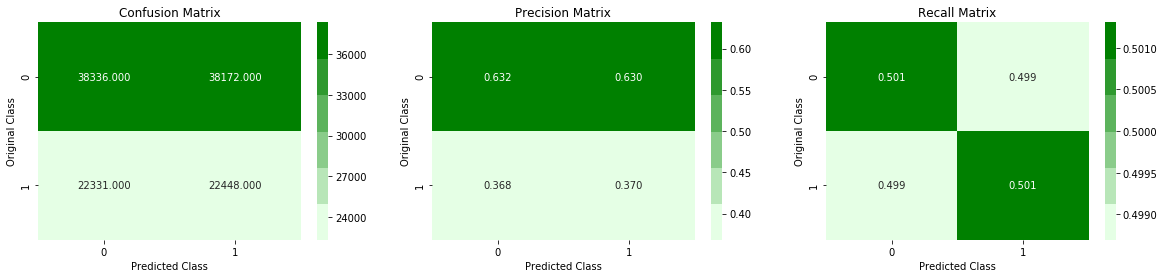

In [124]:
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len, 2))
for i in range(test_len):
    random_probs = np.random.rand(1, 2)
    predicted_y[i] = ((random_probs/sum(sum(random_probs)))[0])

from sklearn.metrics import log_loss
print("Log loss on Test Data using Random Model: ", log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

In [125]:
(np.random.rand(1, 2)/sum(np.random.rand(1, 2)))[0]

array([0.38629283, 3.09639697])

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

In [126]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler

In [127]:
alpha = [1e-05, 0.0001, .001, .01, .1, 10, 20]

In [128]:
alpha

[1e-05, 0.0001, 0.001, 0.01, 0.1, 10, 20]

In [129]:
scaler = StandardScaler()

In [130]:
from sklearn.linear_model import LogisticRegression

In [131]:
error = []
scaled_X_train = scaler.fit_transform(X_train.copy())
scaled_X_test = scaler.transform(X_test.copy())
for al in alpha:
    print('Starting....\n')
    print('Alpha = ', al)
    clf = SGDClassifier(loss='log', max_iter=10000, n_jobs=2, alpha=al)
    clf.fit(scaled_X_train, y_train)
    calibrated_clf = CalibratedClassifierCV(clf, method='isotonic')
    calibrated_clf.fit(scaled_X_train, y_train)
    predicted_y = calibrated_clf.predict_proba(scaled_X_test)
    loss = log_loss(y_test, predicted_y, labels=clf.classes_)
    error.append(loss)
    print('For alpha value {}, the log loss is {}.'.format(al, loss))
    

Starting....

Alpha =  1e-05
For alpha value 1e-05, the log loss is 0.41219096780107867.
Starting....

Alpha =  0.0001
For alpha value 0.0001, the log loss is 0.4003634737762514.
Starting....

Alpha =  0.001
For alpha value 0.001, the log loss is 0.3994447148874383.
Starting....

Alpha =  0.01
For alpha value 0.01, the log loss is 0.414663834919387.
Starting....

Alpha =  0.1
For alpha value 0.1, the log loss is 0.44950439370736683.
Starting....

Alpha =  10
For alpha value 10, the log loss is 0.544930861228575.
Starting....

Alpha =  20
For alpha value 20, the log loss is 0.5534722512683231.


In [ ]:
# Using sigmoid calibration

In [135]:
error = []
scaled_X_train = scaler.fit_transform(X_train.copy())
scaled_X_test = scaler.transform(X_test.copy())
for al in alpha:
    print('Starting....\n')
    print('Alpha = ', al)
    clf = SGDClassifier(loss='log', max_iter=10000, n_jobs=2, alpha=al)
    clf.fit(scaled_X_train, y_train)
    calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid')
    calibrated_clf.fit(scaled_X_train, y_train)
    predicted_y = calibrated_clf.predict_proba(scaled_X_test)
    loss = log_loss(y_test, predicted_y, labels=clf.classes_)
    error.append(loss)
    print('For alpha value {}, the log loss is {}.'.format(al, loss))
    

Starting....

Alpha =  1e-05
For alpha value 1e-05, the log loss is 0.41364570644417537.
Starting....

Alpha =  0.0001
For alpha value 0.0001, the log loss is 0.40692914137887126.
Starting....

Alpha =  0.001
For alpha value 0.001, the log loss is 0.40589922383768173.
Starting....

Alpha =  0.01
For alpha value 0.01, the log loss is 0.41923741532709485.
Starting....

Alpha =  0.1
For alpha value 0.1, the log loss is 0.45702006912178805.
Starting....

Alpha =  10
For alpha value 10, the log loss is 0.5479034726186252.
Starting....

Alpha =  20
For alpha value 20, the log loss is 0.5552973147278608.


In [ ]:
# With oversampling

In [134]:
error = []
scaled_X_train = scaler.fit_transform(X_train.copy())
scaled_X_test = scaler.transform(X_test.copy())
for al in alpha:
    print('Starting....\n')
    print('Alpha = ', al)
    clf = SGDClassifier(loss='log', max_iter=10000, n_jobs=2, alpha=al, class_weight='balanced')
    clf.fit(scaled_X_train, y_train)
    calibrated_clf = CalibratedClassifierCV(clf, method='isotonic')
    calibrated_clf.fit(scaled_X_train, y_train)
    predicted_y = calibrated_clf.predict_proba(scaled_X_test)
    loss = log_loss(y_test, predicted_y, labels=clf.classes_)
    error.append(loss)
    print('For alpha value {}, the log loss is {}.'.format(al, loss))
    

Starting....

Alpha =  1e-05
For alpha value 1e-05, the log loss is 0.40797976264903885.
Starting....

Alpha =  0.0001
For alpha value 0.0001, the log loss is 0.4004054539512811.
Starting....

Alpha =  0.001
For alpha value 0.001, the log loss is 0.39907000191060227.
Starting....

Alpha =  0.01
For alpha value 0.01, the log loss is 0.41461812020873046.
Starting....

Alpha =  0.1
For alpha value 0.1, the log loss is 0.4505832412248718.
Starting....

Alpha =  10
For alpha value 10, the log loss is 0.5460745409327068.
Starting....

Alpha =  20
For alpha value 20, the log loss is 0.5541691876527042.


Text(0.5, 0, "Alpha i's")

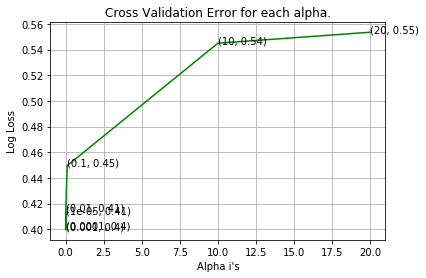

In [132]:
fig, axis = plt.subplots()
axis.plot(alpha, error, c='g')
for i, txt in enumerate(np.round(error, 2)):
    axis.annotate((alpha[i], np.round(txt, 3)), (alpha[i], error[i]))
plt.grid()
plt.title('Cross Validation Error for each alpha.')
plt.ylabel('Log Loss')
plt.xlabel("Alpha i's")

For values of best alpha =  0.001 . The train log loss is  0.3963987549922585
For values of best alpha =  0.001 . The validation/test log loss is  0.399105668289355
Total number of datapoints:  121287


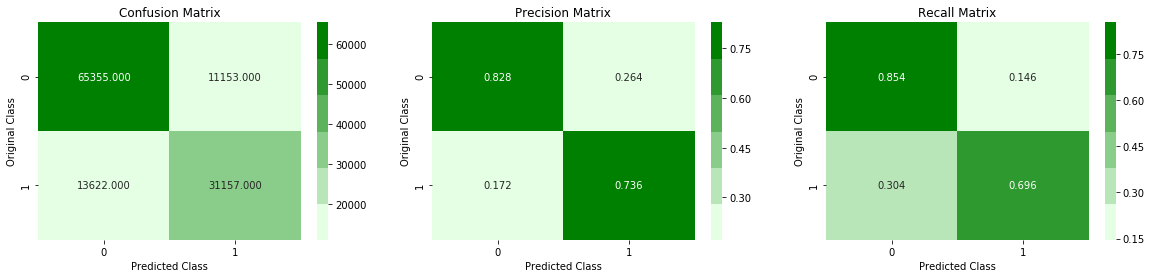

In [133]:
best_alpha = alpha[np.argmin(error)]
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log', max_iter=10000)
clf.fit(scaled_X_train, y_train)
calibrated_clf = CalibratedClassifierCV(clf, method='isotonic')
calibrated_clf.fit(scaled_X_train, y_train)

predict_y_train = calibrated_clf.predict_proba(scaled_X_train)
print('For values of best alpha = ', best_alpha, '. The train log loss is ', log_loss(y_train, predict_y_train))

predict_y_test = calibrated_clf.predict_proba(scaled_X_test)
print('For values of best alpha = ', best_alpha, '. The validation/test log loss is ', log_loss(y_test, predict_y_test))

predict_y_test = np.argmax(predict_y_test, axis=1)

print('Total number of datapoints: ', len(predict_y_test))

plot_confusion_matrix(y_test, predict_y_test)

In [ ]:
# Observations
# The train and test loss is almost the same meaning NO OVERFITTING.

## Linear SVM

In [136]:
error = []
for al in alpha:
    print('Starting....\n')
    print('Alpha = ', al)
    clf = SGDClassifier(loss='hinge', max_iter=10000, n_jobs=2, alpha=al)
    clf.fit(scaled_X_train, y_train)
    calibrated_clf = CalibratedClassifierCV(clf, method='isotonic')
    calibrated_clf.fit(scaled_X_train, y_train)
    predicted_y = calibrated_clf.predict_proba(scaled_X_test)
    loss = log_loss(y_test, predicted_y, labels=clf.classes_)
    error.append(loss)
    print('For alpha value {}, the log loss is {}.'.format(al, loss))

Starting....

Alpha =  1e-05
For alpha value 1e-05, the log loss is 0.41688293327067705.
Starting....

Alpha =  0.0001
For alpha value 0.0001, the log loss is 0.4019157517825281.
Starting....

Alpha =  0.001
For alpha value 0.001, the log loss is 0.3993592672210866.
Starting....

Alpha =  0.01
For alpha value 0.01, the log loss is 0.4075744098370468.
Starting....

Alpha =  0.1
For alpha value 0.1, the log loss is 0.43791429866098786.
Starting....

Alpha =  10
For alpha value 10, the log loss is 0.5048789552662748.
Starting....

Alpha =  20
For alpha value 20, the log loss is 0.5351989882704875.


For values of best alpha =  0.001 . The train log loss is  0.397102092955059
For values of best alpha =  0.001 . The validation/test log loss is  0.3993445230348124
Total number of datapoints:  121287


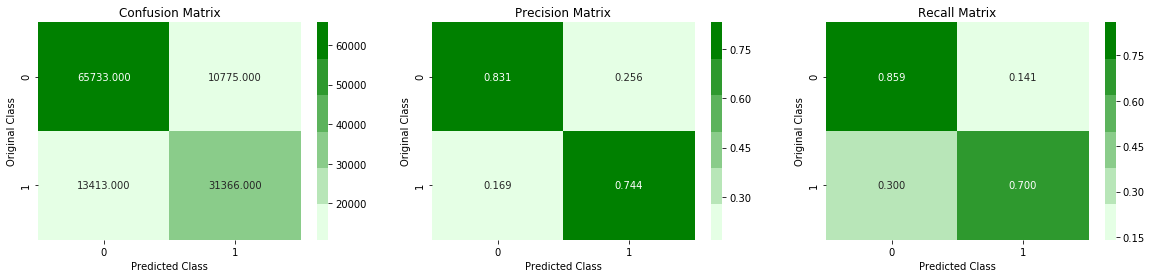

In [137]:
best_alpha = alpha[np.argmin(error)]
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='hinge', max_iter=10000)
clf.fit(scaled_X_train, y_train)
calibrated_clf = CalibratedClassifierCV(clf, method='isotonic')
calibrated_clf.fit(scaled_X_train, y_train)

predict_y_train = calibrated_clf.predict_proba(scaled_X_train)
print('For values of best alpha = ', best_alpha, '. The train log loss is ', log_loss(y_train, predict_y_train))

predict_y_test = calibrated_clf.predict_proba(scaled_X_test)
print('For values of best alpha = ', best_alpha, '. The validation/test log loss is ', log_loss(y_test, predict_y_test))

predict_y_test = np.argmax(predict_y_test, axis=1)

print('Total number of datapoints: ', len(predict_y_test))

plot_confusion_matrix(y_test, predict_y_test)

<h2> 4.6 XGBoost </h2>

In [138]:
import xgboost as xgb

C:\Users\hp\Anaconda3\lib\site-packages\xgboost\__init__.py:29: FutureWarning:

Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.



In [139]:
params = {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'max_depth': 4, 'eta': .02}

In [ ]:
# d_train = xgb.DMatrix(X_train, label=y_train)
# d_test = xgb.DMatrix(X_test, label=y_test)

In [ ]:
# watchlist = [(d_train, 'train'), (d_test, 'validation')]

In [ ]:
# xgb_clf = xgb.train(params=params, dtrain=d_train, num_boost_round=400, verbose_eval=10)

In [ ]:
# predict_y = xgb_clf.predict(d_test)
# print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [152]:
# Hyperparameter tuning xgboost
param_grid = {'max_depth': [5, 8],
             'colsample_bytree': [.7],
             'n_estimators': [100, 200],
             'booster': ['gbtree']}

In [153]:
from sklearn.model_selection import RandomizedSearchCV

In [154]:
grid = RandomizedSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic'), param_distributions=param_grid,
                   scoring='neg_log_loss', cv=5, verbose=3, n_jobs=2)

In [155]:
grid.fit(X_train, y_train)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning:

The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed: 60.6min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                     

In [150]:
grid.best_score_

-0.36497306751277125

In [156]:
grid.best_score_

-0.3291334653598018

In [151]:
grid.best_params_

{'booster': 'gbtree',
 'colsample_bytree': 0.7,
 'max_depth': 3,
 'n_estimators': 30}

In [157]:
grid.best_params_

{'booster': 'gbtree',
 'colsample_bytree': 0.7,
 'max_depth': 5,
 'n_estimators': 100}

In [158]:
xgb_clf = xgb.XGBClassifier(booster='gbtree', colsample_bytree=0.7, max_depth=5, n_estimators=100)

In [160]:
xgb_clf.fit(X_train, y_train)
calibrated_clf = CalibratedClassifierCV(xgb_clf, method='isotonic')
calibrated_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=0.7,
                                                    gamma=0, gpu_id=-1,
                                                    importance_type='gain',
                                                    interaction_constraints='',
                                                    learning_rate=0.300000012,
                                                    max_delta_step=0,
                                                    max_depth=5,
                                                    min_child_weight=1,
                                                    missing=nan,
                                                    monotone_con

In [161]:
predict_y = calibrated_clf.predict(X_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

The test log loss is: 5.5416611540172465
